# USPEX LXD point-source reduction example

Last updated 23 May 2025

This notebook demonstrates the reduction of a (upgraded) SPEX LXD point-source data using the test data provided with the code in tests/test_data/raw/uspex-LXD

## Steps:
* setup instrument parameters
* reduce calibration data
* extract science point source
* extract telluric standard point source
* combine individual science spectra into one spectrum
* combine individual telluric spectra into one spectrum
* telluric calibration science spectrum


In [1]:
# import package and check
import pyspextool as ps
import os, sys
import numpy as np
import matplotlib.pyplot as plt

help(ps)

Help on package pyspextool:

NAME
    pyspextool

DESCRIPTION
    PySpexTool is a package intended to contain core functionality and some
    common tools needed for performing reduction for SpeX instrument in
    Python.

PACKAGE CONTENTS
    batch (package)
    combine (package)
    config
    extract (package)
    fit (package)
    io (package)
    plot (package)
    pyspextoolerror
    setup_utils
    telluric (package)
    utils (package)

FILE
    /Users/chsu/projects/pyspextool/src/pyspextool/__init__.py




# Set up

While users should be able to run the Jupyter notebook tutorials without changing the output paths, users are encouraged to move the data folder and rename the output paths. Users can define the output paths, including the `cal`, `proc`, and `qa` in the next cell to where users would like to save their data.

The wavelength calibration is different from Prism and SXD, where user needs to set up sky frames.


sky_files : str or list or None
    If type NoneType, then only arc files are required. One can run ps.extract.make_wavecal? to check the possible options, and the doc string of sky_files is shown below:
    
<blockquote>
    If type is str, then a comma-separated string of full file names, 
    e.g. 'spc-00001.a.fits, spc-00002.b.fits'.

    If type is list, then a two-element list where
    files[0] is a str giving the perfix, files[1] is a str giving the 
    index numbers of the files, e.g. ['spc', '1-2,5-10,13,14'].
</blockquote>

In [2]:
# ============================================================================
# CONFIGURATION - Define paths, files, and reduction parameters
# ============================================================================

# Instrument configuration
instrument = 'uspex'        # Upgraded SpeX instrument
inst_mode = 'LXD'        # LXD mode

# Determine data paths
# file_base: Root directory of the pyspextool installation
file_base = ps.__file__.split('/src/')[0]
topbase = os.getenv("HOME")  # User's home directory

# Data directories
# raw: Location of raw FITS files from the telescope
raw = file_base + '/tests/test_data/raw/' + instrument + '-' + inst_mode + '/data/'

# Output directories (users can customize these paths)
cal = topbase + '/test_pyspextool/test_data/processed/' + instrument + '-' + inst_mode + '/cals/'   # Calibration files
proc = topbase + '/test_pyspextool/test_data/processed/' + instrument + '-' + inst_mode + '/proc/' # Processed spectra
qa = topbase + '/test_pyspextool/test_data/processed/' + instrument + '-' + inst_mode + '/qa/'     # QA plots

# File naming prefixes
src_prefix = 'uspc'        # Science and standard star files
flat_prefix = 'uflat'      # Flat field files
arc_prefix = 'uarc'        # Arc lamp files

# ============================================================================
# INPUT FILES - Define which files to use
# ============================================================================

# Target and standard names (customize for your data)
obj_name = 'J1104+1959'    # Science target name
std_name = 'HD101060'      # Telluric standard name

# File number ranges
files = '1-8'              # Science observations
std_files = '9-14'         # Standard observations
flat_files = '15-19'       # Flat fields
wave_files = '20'          # Arc lamps
sky_files = None           # Sky frames (None = use arc only)

# ============================================================================
# EXTRACTION PARAMETERS
# ============================================================================

# Observing mode
mode = 'A-B'               # A-B nodding (subtract beam positions)
naps = 1 if mode == 'A' else 2
aperture_signs = None

# Aperture configuration
aperture_find = ['auto',2] # Auto-find with 2-sigma threshold
aperture = 1.5             # Aperture radius (arcsec)
include_orders = None      # Orders to extract (None = all)

# Corrections to apply
correct_bias = True        # Bias correction
correct_linearity = True   # Linearity correction
flat_field = True          # Flat field correction
fix_badpixels = True       # Bad pixel interpolation

# Background subtraction
bg_annulus = [2,2.5]       # Background annulus (inner, outer radius in arcsec)
psf_radius = None          # PSF radius (None = aperture photometry)

# Calibration file names
flatfield_file = 'flat%s.fits' % flat_files
wavecal_file = 'wavecal%s.fits' % wave_files

# ============================================================================
# QA AND OUTPUT SETTINGS
# ============================================================================

verbose = True
qa_show = True             # Display QA plots
qa_write = True            # Save QA plots
qa_extension = '.pdf'
qa_showblock = True
write_model_spectra = False

# Create output directories
for directory in [cal, proc, qa]:
    if not os.path.exists(directory):
        os.makedirs(directory)


In [3]:
# ============================================================================
# GENERATE OUTPUT PREFIX
# ============================================================================
# Build filename prefix encoding applied corrections

output_prefix = mode
if correct_bias is True:  output_prefix += '_bc'
if correct_linearity is True:  output_prefix += '_lc'
if flat_field is True:  output_prefix += '_flat'
if flat_field is not None:  output_prefix += '_wc'
if fix_badpixels is True:  output_prefix += '_fxbdpx'

output_prefix += '-'


In [4]:
# ============================================================================
# INITIALIZE PYSPEXTOOL
# ============================================================================

ps.pyspextool_setup(instrument,
                    raw_path=raw,
                    qa_path=qa,
                    cal_path=cal,
                    proc_path=proc,
                    verbose=verbose,
                    qa_write=qa_write,
                    qa_show=qa_show,
                    qa_showblock=qa_showblock)


INFO:  pySpextool Setup
----------------------

INFO:  Verbose set to True. 
 Logging level set to 20
INFO:  Instrument set to uspex
INFO:  Paths set
INFO:  QA settings set


## Calibrations

INFO:  Generating Flat Field
---------------------------

INFO:  Loading the images.
INFO:  Loading images(s) flat-00045.a.fits, flat-00046.a.fits, flat-00047.a.fits, flat-00048.a.fits, flat-00049.a.fits correcting bias drift, and not correcting for non-linearity.


100% |**********************************************************************|


INFO:  Scaling the images.
INFO:  Medianing the images.
INFO:  Locating the orders.


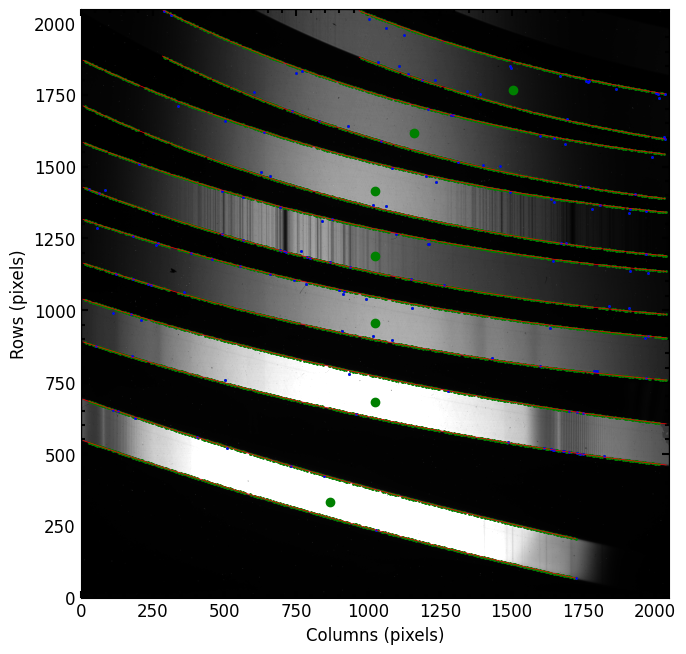

INFO:  Normalizing the median flat.


100% |**********************************************************************|


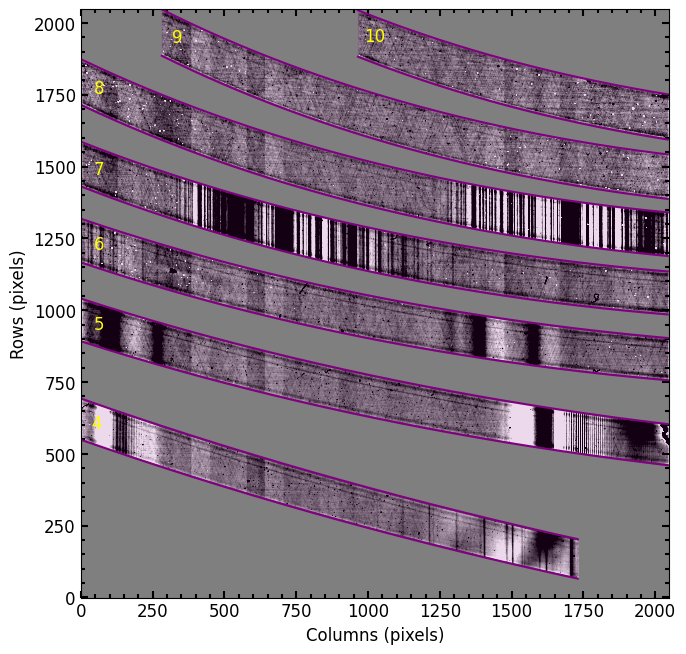

INFO:  Flat field file flat45-49.fits written to disk.



In [5]:
# conduct calibrations
ps.extract.make_flat([flat_prefix,flat_files],flatfield_file.rstrip('.fits'), verbose=True)

In [6]:
# Get help on make_wavecal function
help(ps.extract.make_wavecal)

Signature:
ps.extract.make_wavecal(
    arc_files: str | list,
    flat_file: str,
    output_filename: str,
    sky_files: str = None,
    linearity_correction=True,
    detector_info: dict = None,
    use_stored_solution: bool = False,
    verbose: bool = None,
    qa_show: bool = None,
    qa_showscale: float | int = None,
    qa_showblock: bool = None,
    qa_write_findlines: bool = False,
    qa_write: bool = None,
)
Docstring:
To create a spextool wavecal file.

Parameters
----------
arc_files : str or list
    If type is str, then a comma-separated string of full file names, 
    e.g. 'spc-00001.a.fits, spc-00002.b.fits'.

    If type is list, then a two-element list where
    files[0] is a str giving the perfix, files[1] is a str giving the 
    index numbers of the files, e.g. ['spc', '1-2,5-10,13,14'].
    
flat_file : str
    The full path of a pySpextool flat field file.

output_filename : str
    The filename of the wavecal file to written to disk.      

sky_files : str o

INFO:  Generating Wavelength Solution
------------------------------------

INFO:  Creating the arc image.
INFO:  Creating the sky image.
INFO:  Loading images(s) spc-00023.a.fits, spc-00024.b.fits correcting bias drift, and correcting for non-linearity.


100% |**********************************************************************|


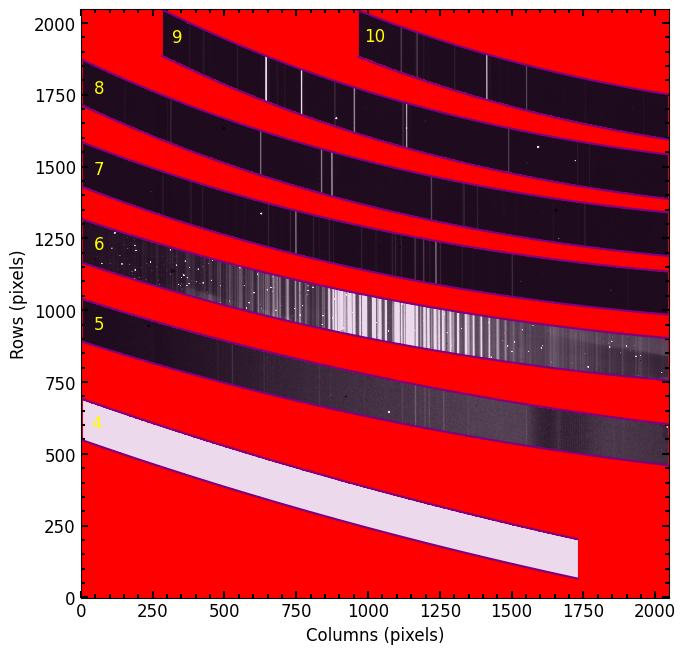

INFO:  Sum extracting 1 aperture in 7 orders (without background subtraction).


100% |**********************************************************************|


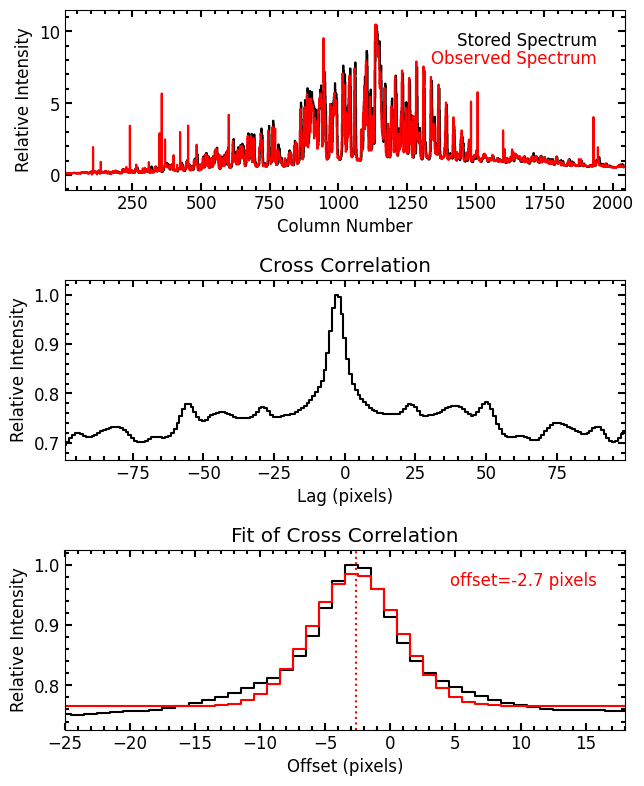

INFO:  Finding the lines.
INFO:  Determining the wavelength solution.


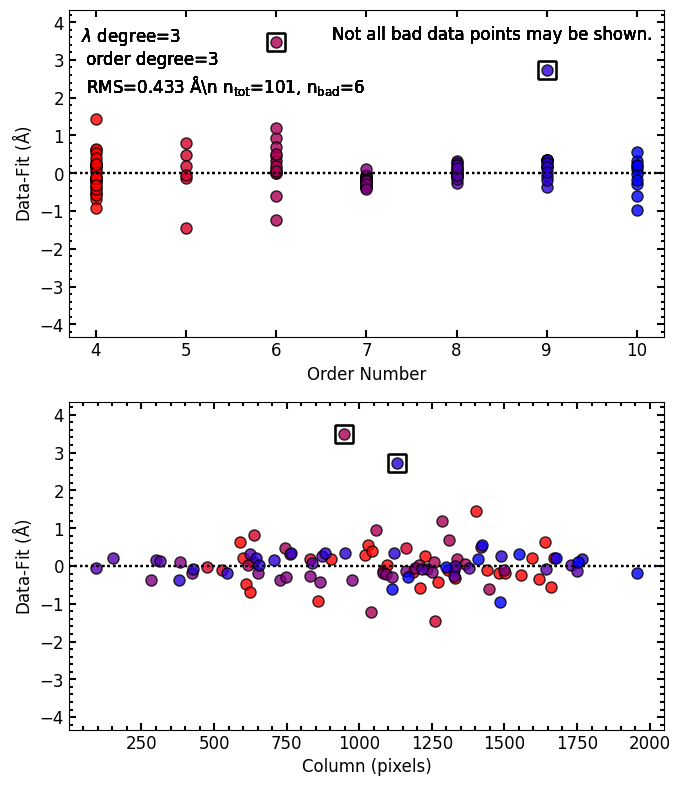

INFO:  Writing wavecal to disk.
INFO:  Wavecal file wavecal43-44.fits written to disk.



In [7]:
# note that we are passing the keyword sky_files into make_wavecal
ps.extract.make_wavecal([arc_prefix,wave_files], flatfield_file, wavecal_file.rstrip('.fits'), sky_files=sky_files)

## Extract telluric standard files

INFO:  Setting reduction mode to A-B.
INFO:  Loading the flat file flat45-49.fits.
INFO:  Loading the wavecal file wavecal43-44.fits.
INFO:  Loading the atmospheric tranmission at R=2000.
INFO:  Loading images(s) spc-00033.a.fits, spc-00034.b.fits correcting bias drift, and correcting for non-linearity.


100% |**********************************************************************|


INFO:  Flat fielding the image.
INFO:  Rectifying the orders.


100% |**********************************************************************|


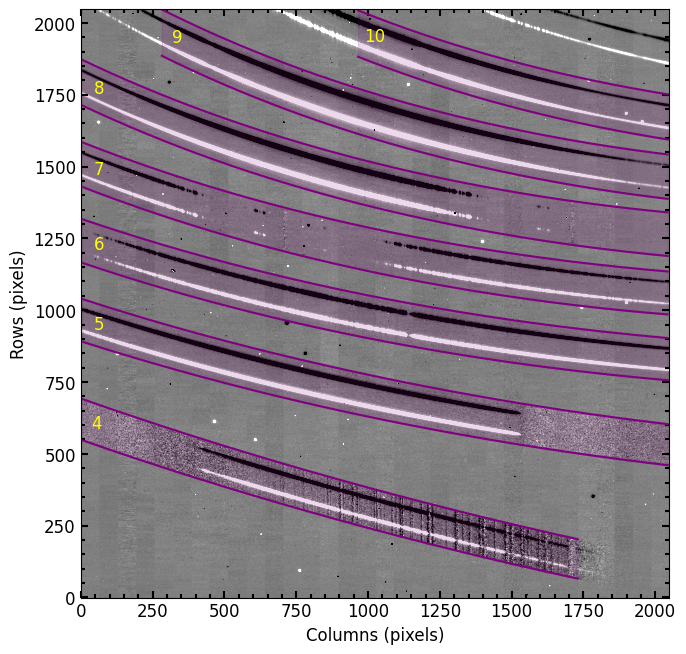

INFO:  Creating the 1D spatial profiles.


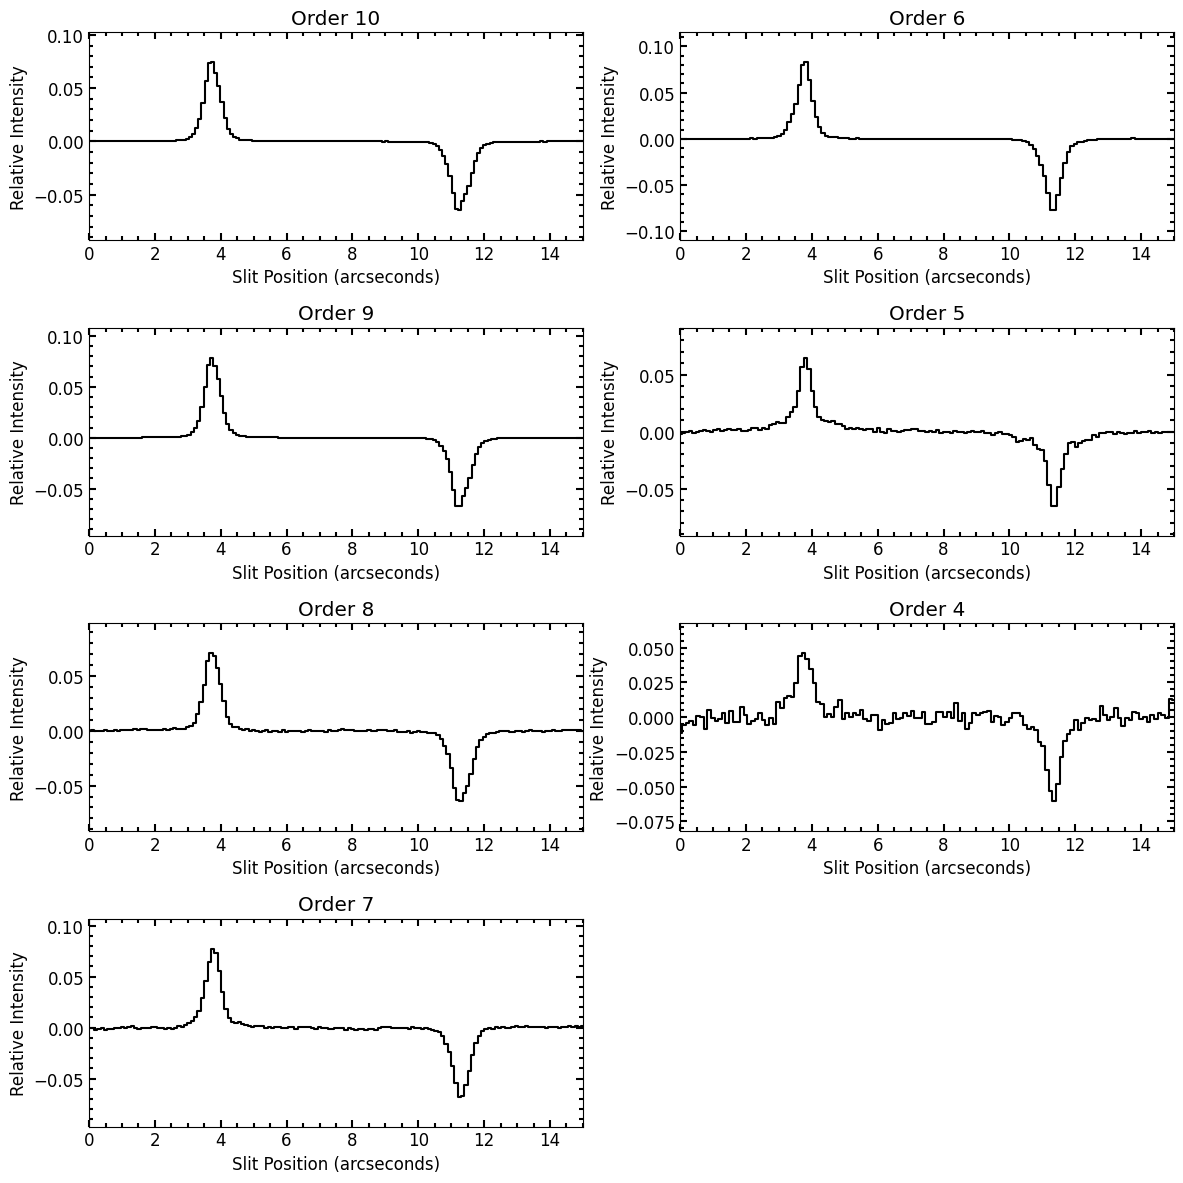

INFO:  Locating the apertures.
INFO:  Aperture signs are (+, -).


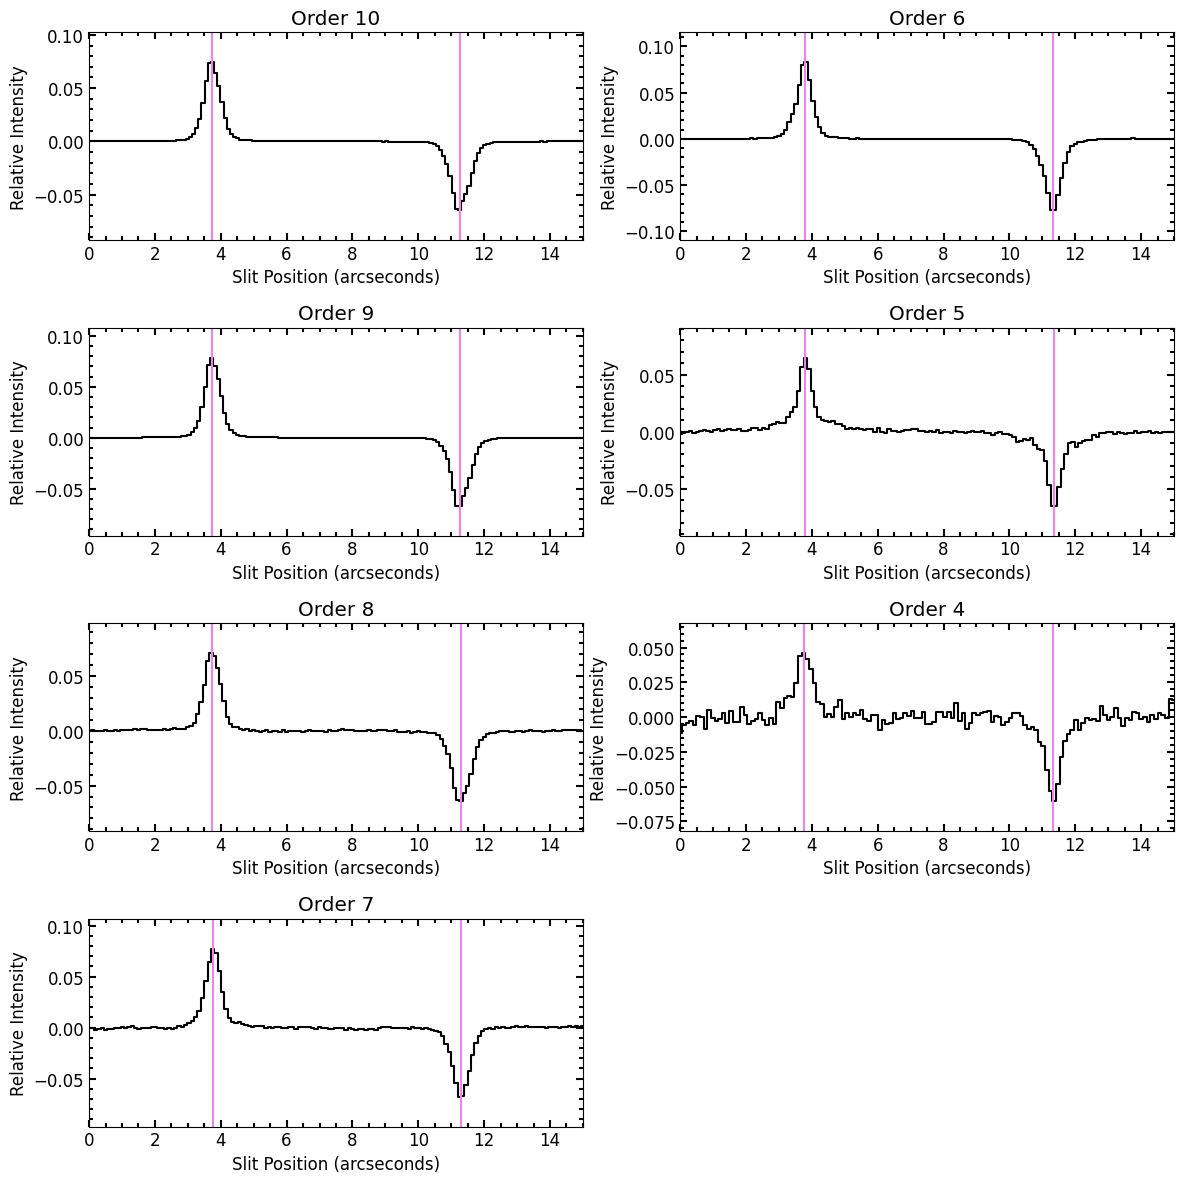

INFO:  Tracing apertures.


100% |**********************************************************************|


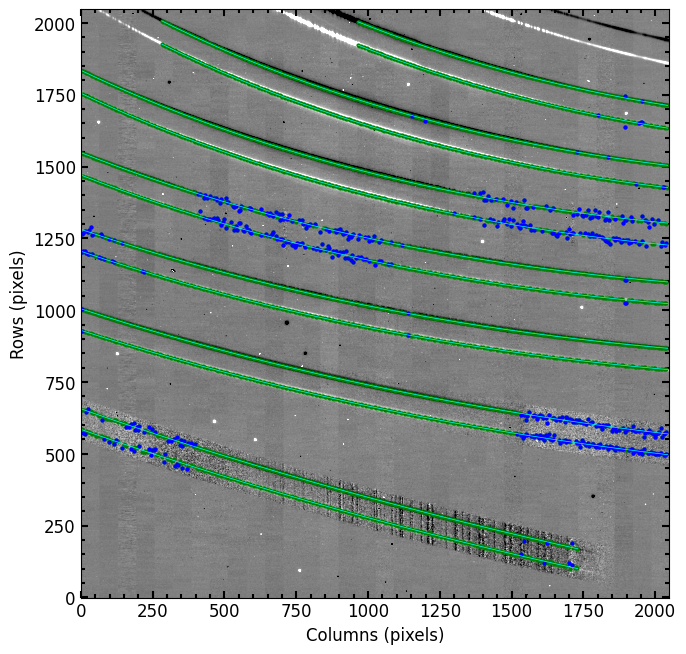

INFO:  Defining aperture parameters.


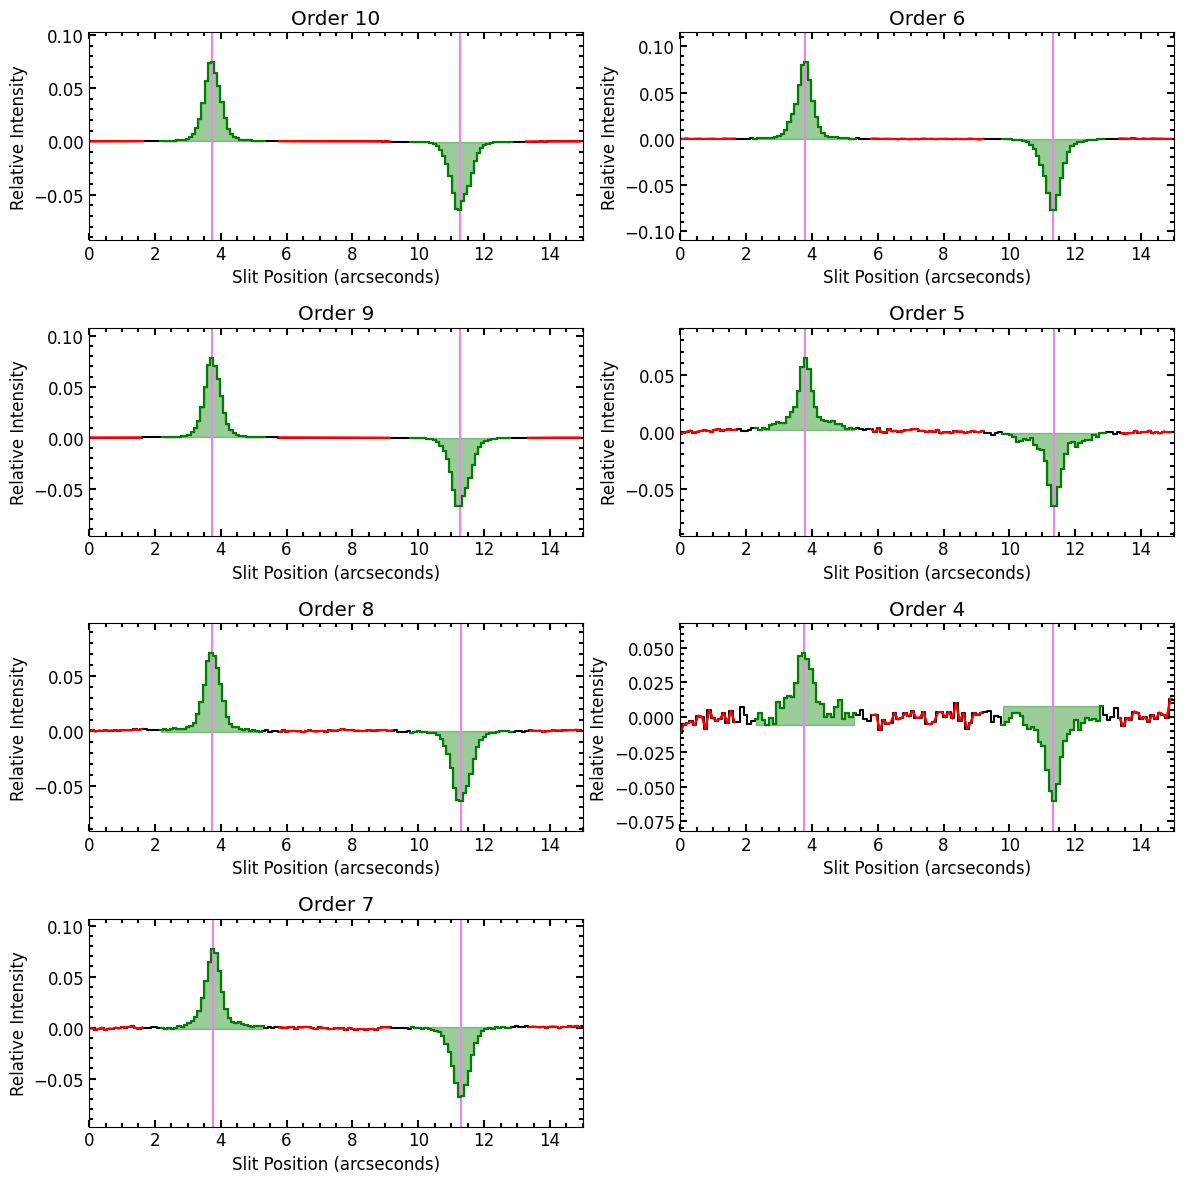

INFO:  Sum extracting 2 apertures in 7 orders (with background subtraction).


INFO:  Wrote file(s) A-B_bc_lc_flat_wc_fxbdpx-00033.fits, A-B_bc_lc_flat_wc_fxbdpx-00034.fits to proc/.



100% |**********************************************************************|


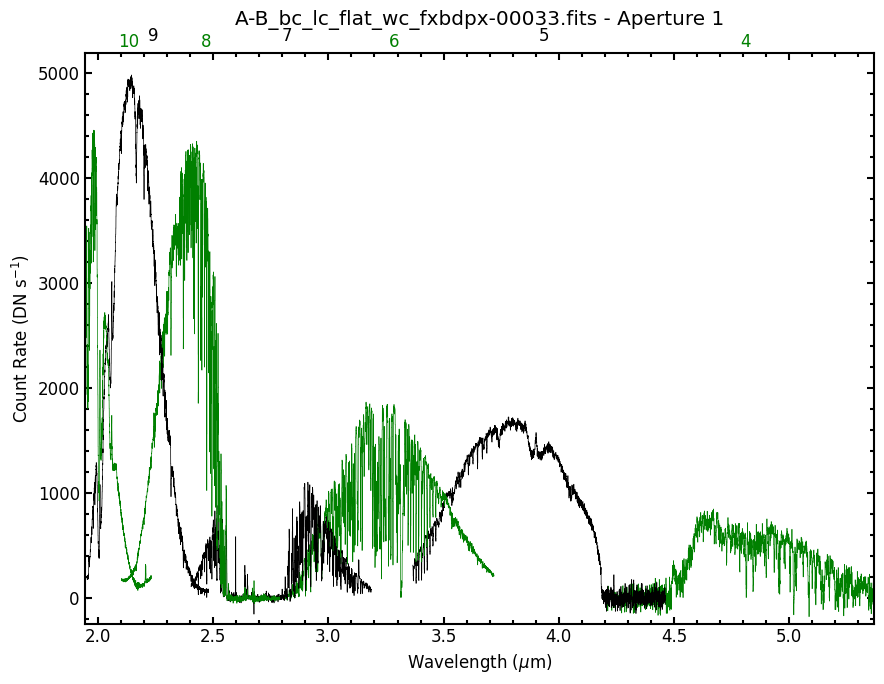

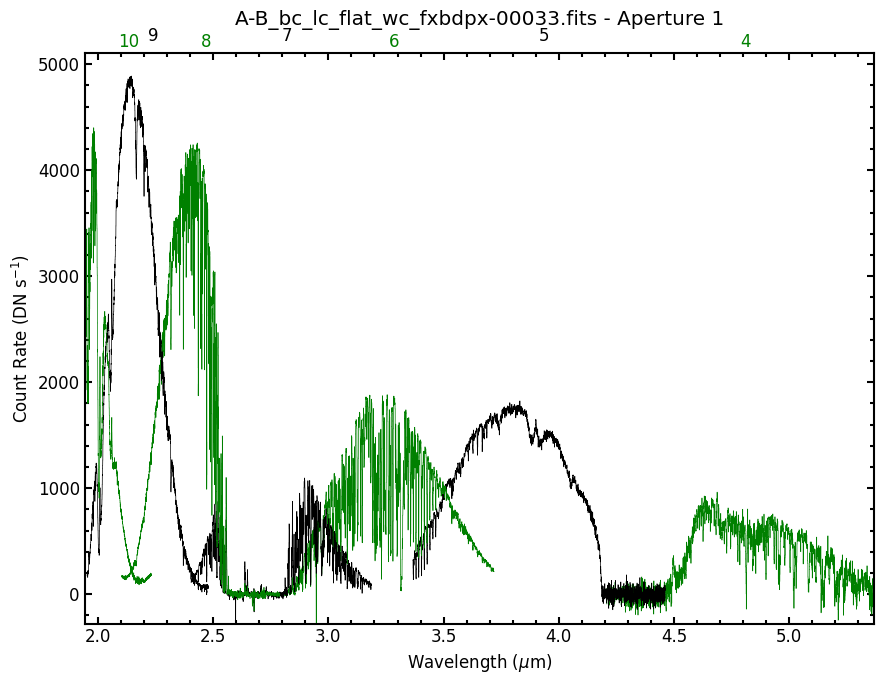

In [8]:
# ============================================================================
# EXTRACT STANDARD
# ============================================================================
# Extract spectra from telluric standard observations

ps.extract.extract(mode,
                   [src_prefix, std_files],
                   flatfield_file,
                   wavecal_file,
                   aperture_find,
                   aperture,
                   flat_field=flat_field,
                   linearity_correction=correct_linearity,
                   output_prefix=output_prefix,
                   write_rectified_orders=False,
                   aperture_signs=aperture_signs,
                   include_orders=include_orders,
                   bg_annulus=bg_annulus,
                   fix_badpixels=fix_badpixels,
                   psf_radius=psf_radius,
                   detector_info={'correct_bias':correct_bias})


## Extract science files

INFO:  Setting reduction mode to A-B.
INFO:  Loading the flat file flat45-49.fits.
INFO:  Loading the wavecal file wavecal43-44.fits.
INFO:  Loading the atmospheric tranmission at R=2000.
INFO:  Loading images(s) spc-00023.a.fits, spc-00024.b.fits correcting bias drift, and correcting for non-linearity.


100% |**********************************************************************|


INFO:  Flat fielding the image.
INFO:  Rectifying the orders.


100% |**********************************************************************|


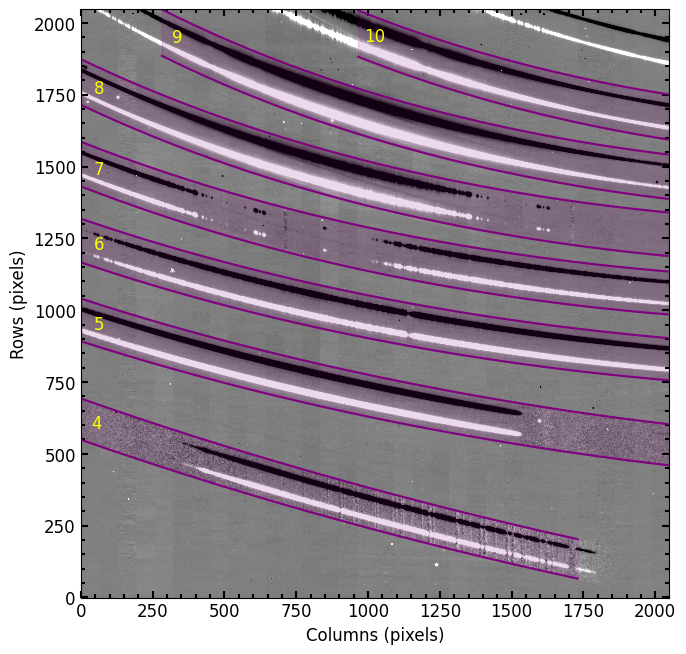

INFO:  Creating the 1D spatial profiles.


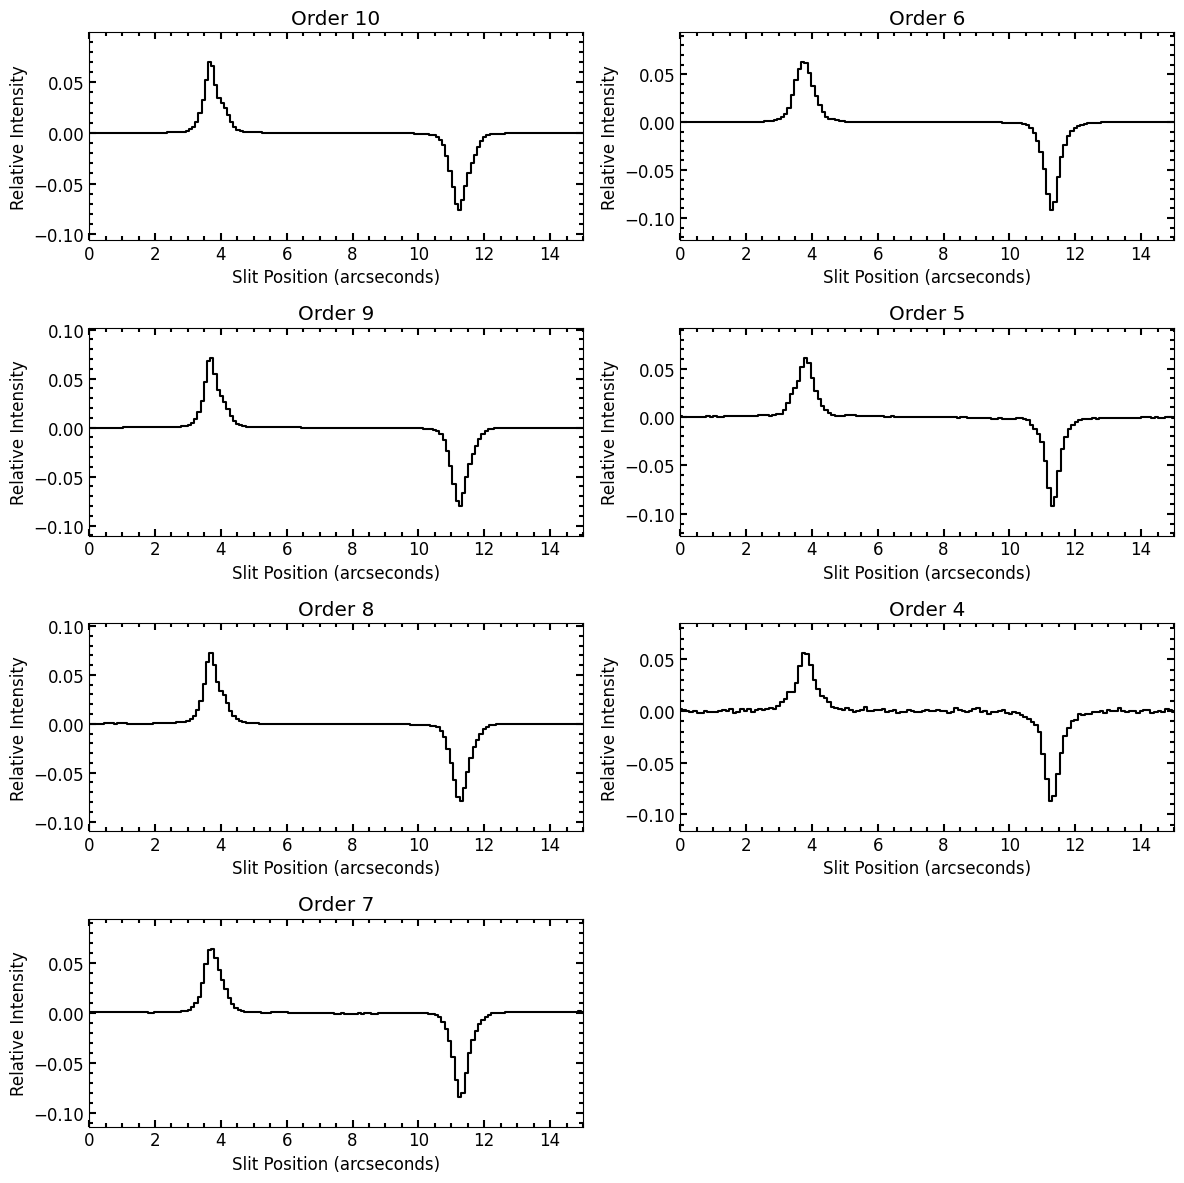

INFO:  Locating the apertures.
INFO:  Aperture signs are (+, -).


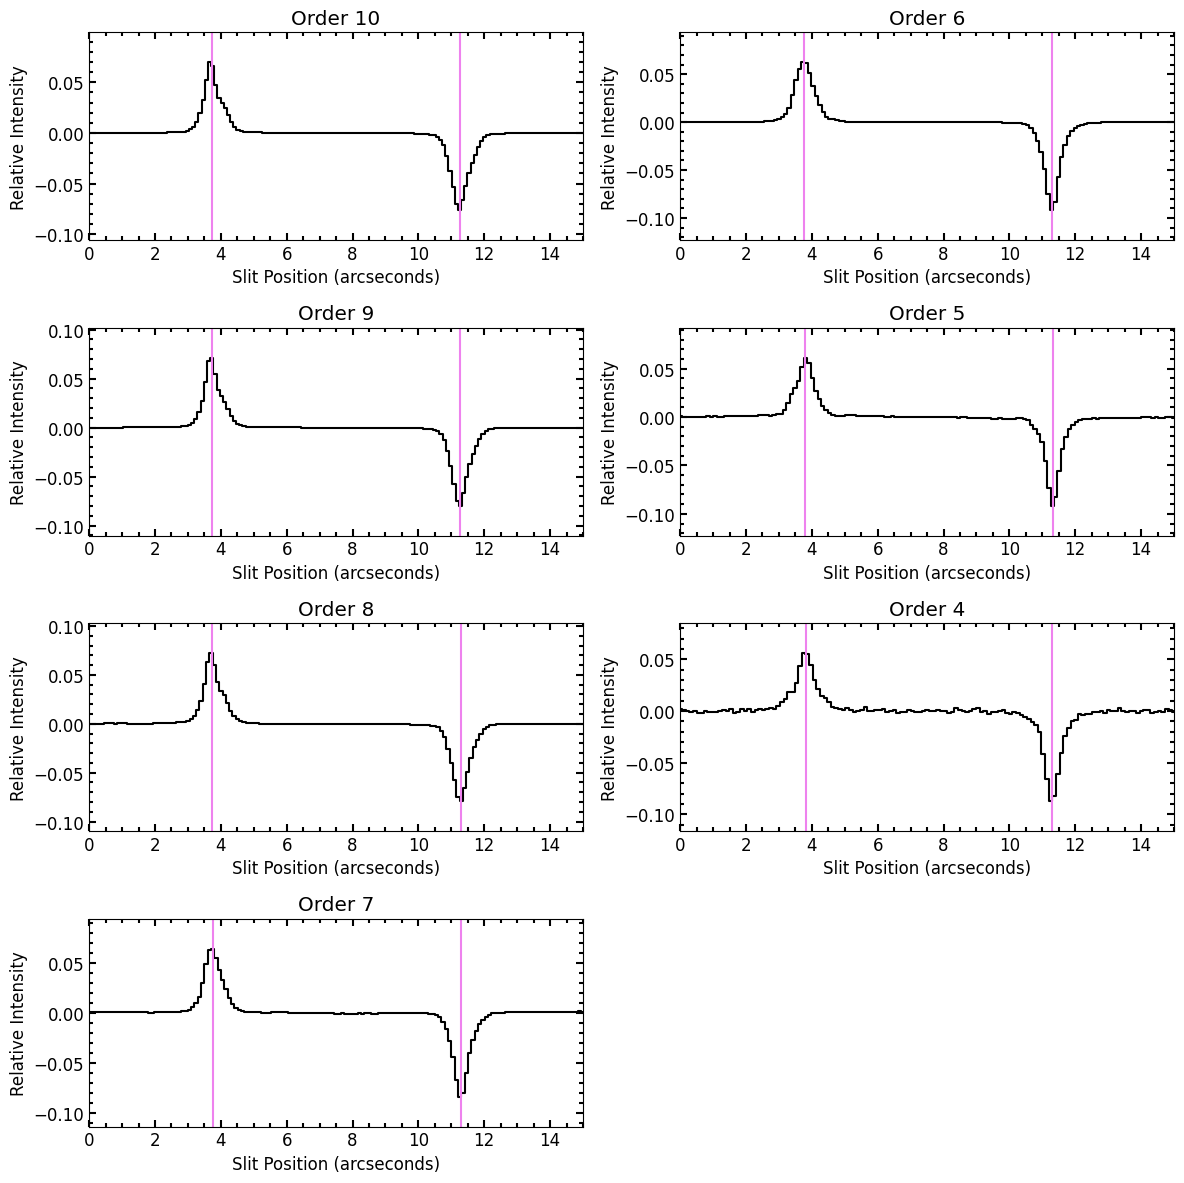

INFO:  Tracing apertures.


100% |**********************************************************************|


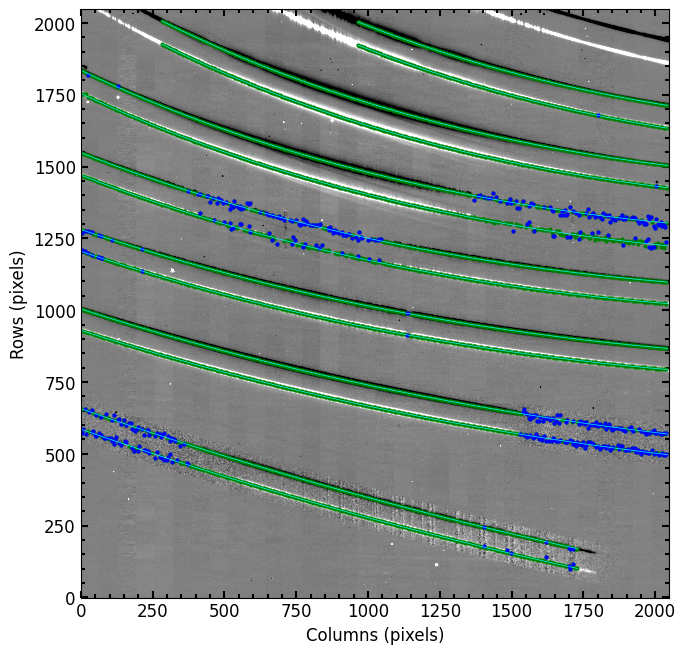

INFO:  Defining aperture parameters.


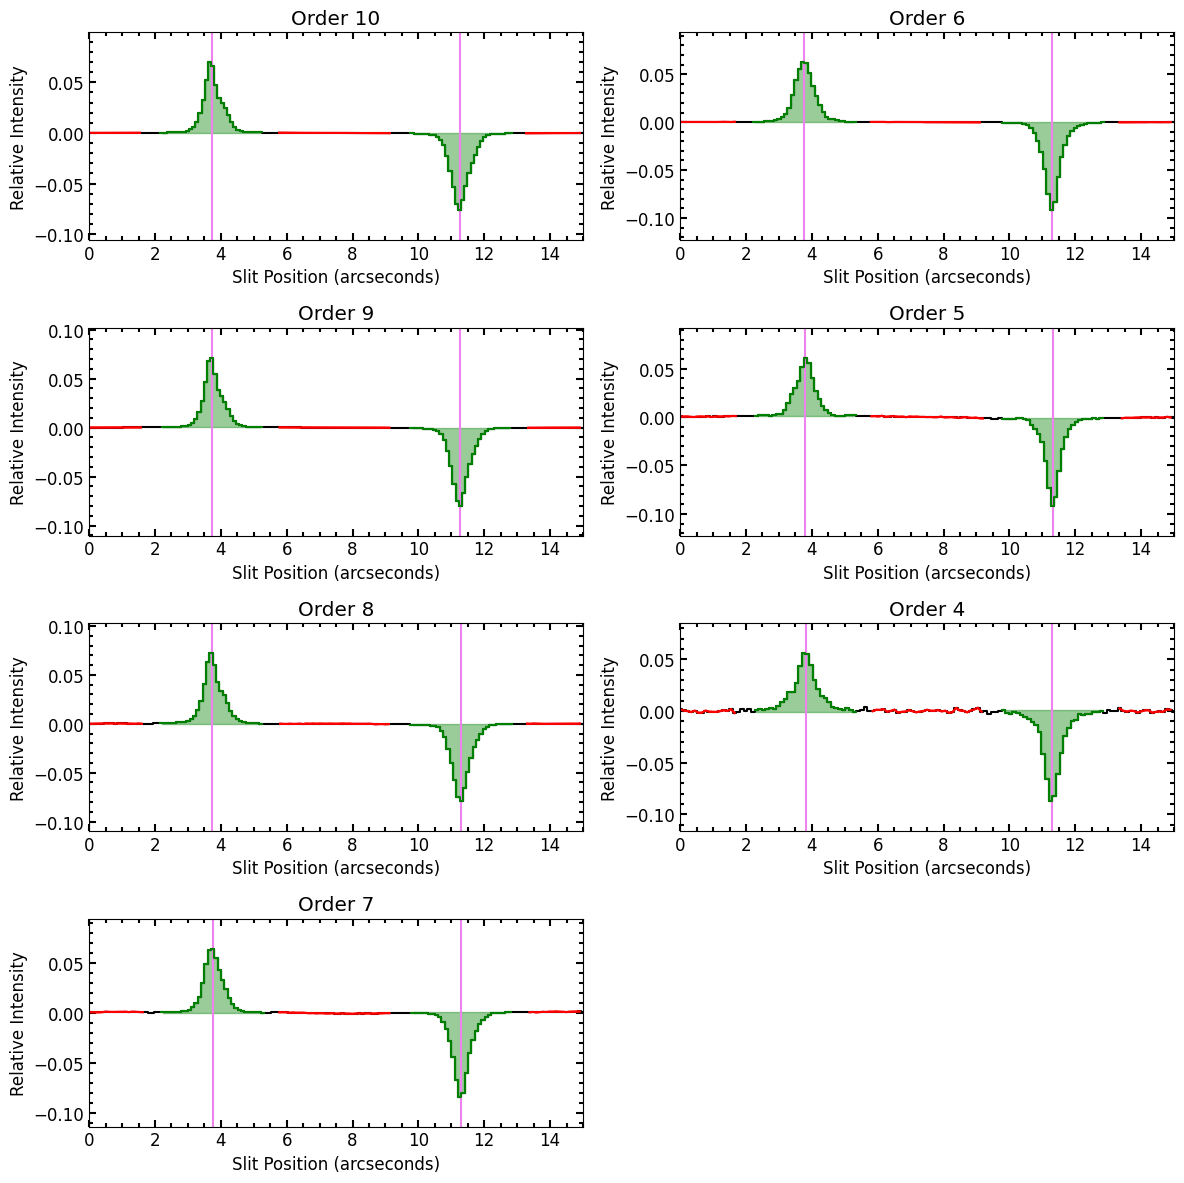

INFO:  Sum extracting 2 apertures in 7 orders (with background subtraction).


INFO:  Wrote file(s) A-B_bc_lc_flat_wc_fxbdpx-00023.fits, A-B_bc_lc_flat_wc_fxbdpx-00024.fits to proc/.



100% |**********************************************************************|


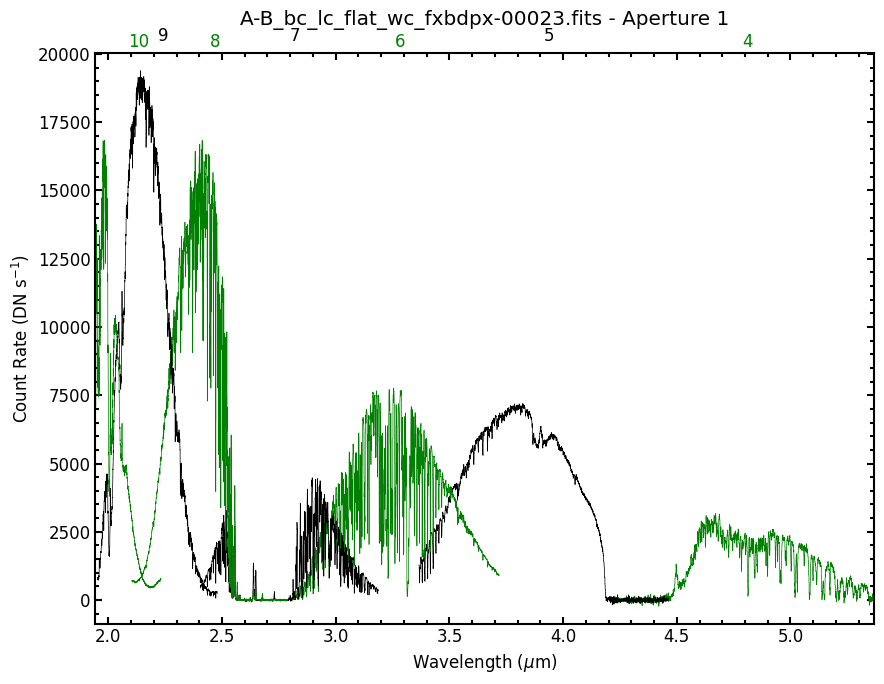

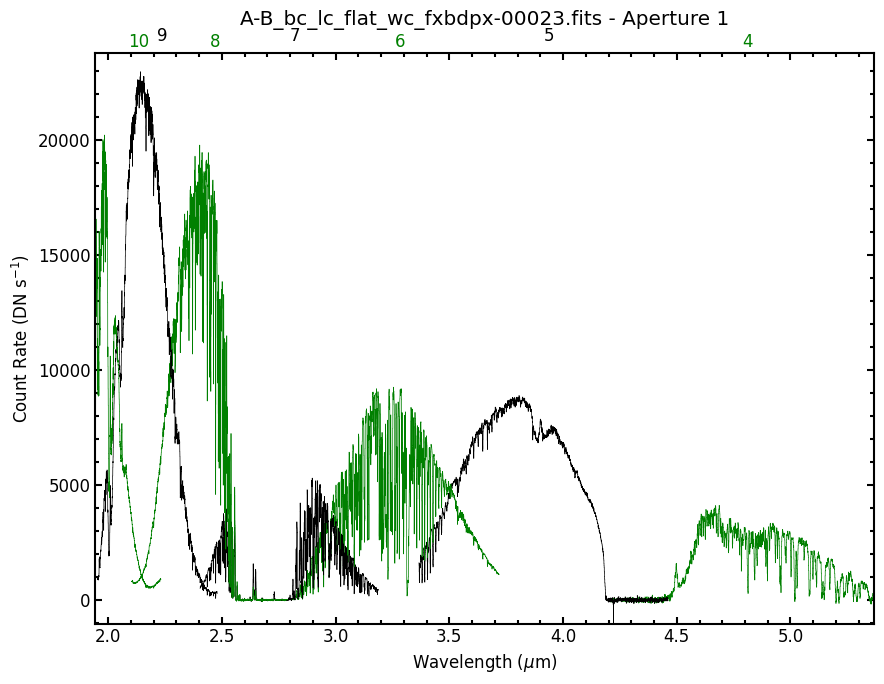

In [9]:
# ============================================================================
# EXTRACT SCIENCE
# ============================================================================
# Extract spectra from science target observations

ps.extract.extract(mode,
                   [src_prefix, files],
                   flatfield_file,
                   wavecal_file,
                   aperture_find,
                   aperture,
                   flat_field=flat_field,
                   linearity_correction=correct_linearity,
                   output_prefix=output_prefix,
                   write_rectified_orders=False,
                   aperture_signs=aperture_signs,
                   include_orders=include_orders,
                   bg_annulus=bg_annulus,
                   fix_badpixels=fix_badpixels,
                   psf_radius=psf_radius,
                   detector_info={'correct_bias':correct_bias})


## Combine standard and science spectra

INFO:  Combining Spectra
-----------------------

INFO:  Loading the spectra.


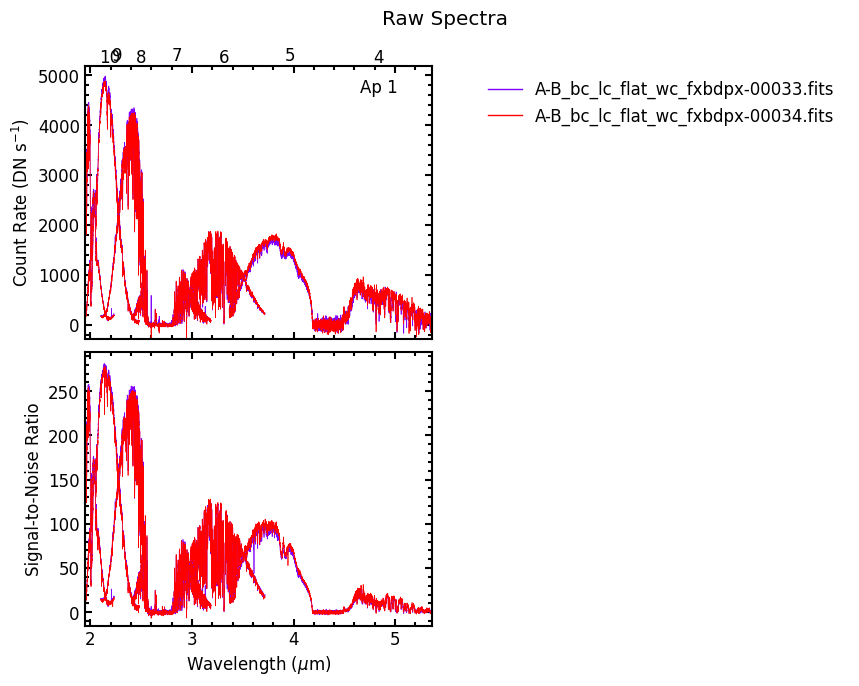

INFO:  Scaling the spectra to a common intensity level.
INFO:  Using order 7 to determine scale factors.


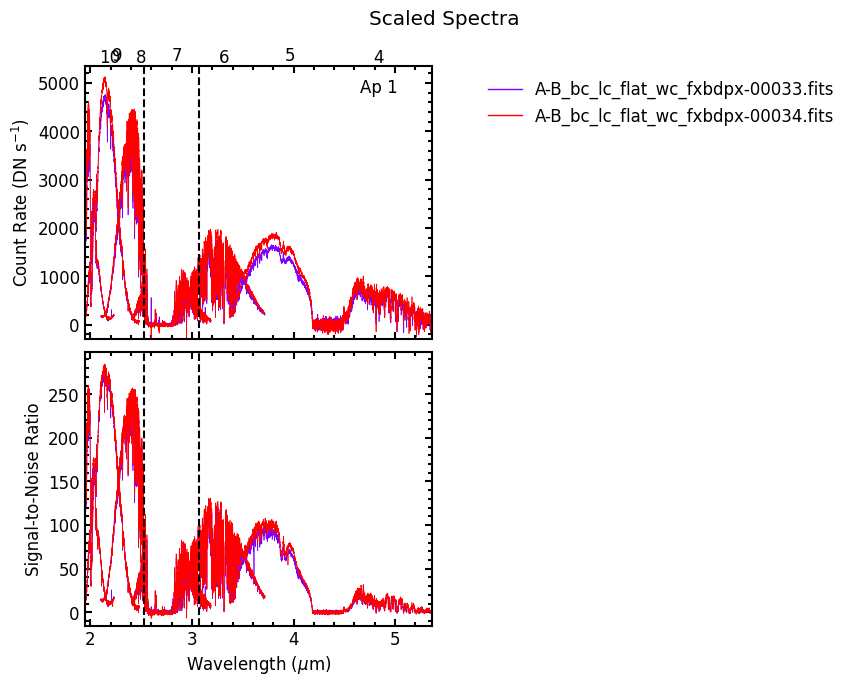

INFO:  Combining the spectra using a robust weighted mean.
INFO:  Wrote file HD223352.fits to proc/.


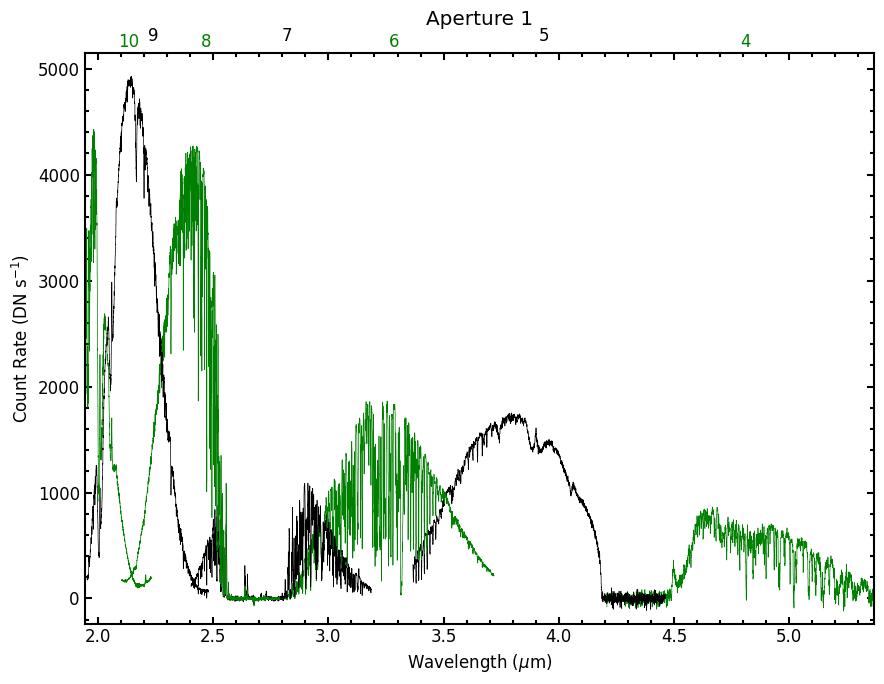

In [10]:
# Combine standard spectra
ps.combine.combine(['A-B_bc_lc_flat_wc_fxbdpx-', std_files], std_name)


INFO:  Combining Spectra
-----------------------

INFO:  Loading the spectra.


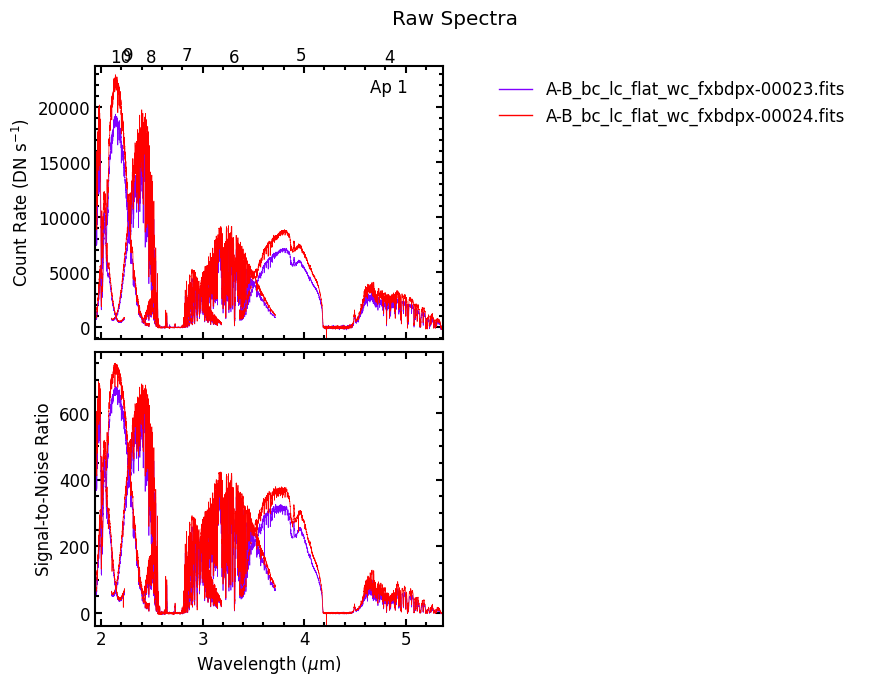

INFO:  Scaling the spectra to a common intensity level.
INFO:  Using order 7 to determine scale factors.


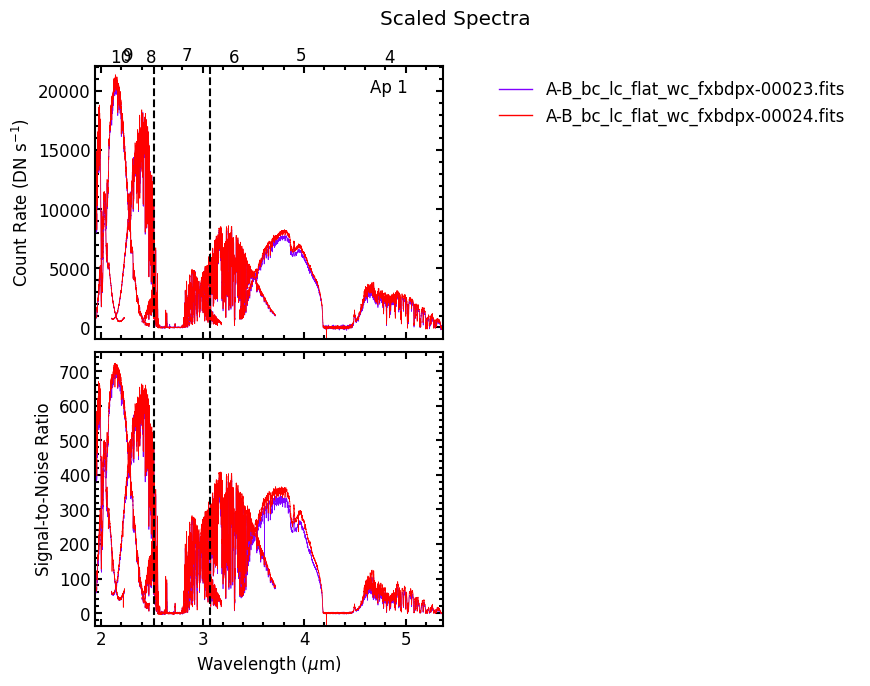

INFO:  Combining the spectra using a robust weighted mean.
INFO:  Wrote file CD-23_17771A.fits to proc/.


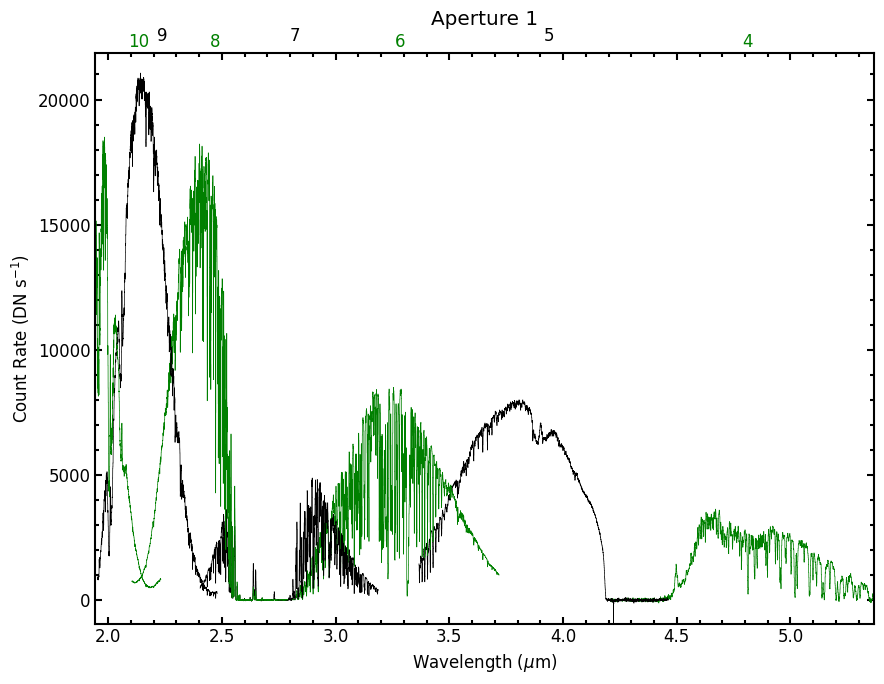

In [11]:
# Combine science target spectra
ps.combine.combine(['A-B_bc_lc_flat_wc_fxbdpx-', files], obj_name)


# Perform telluric correction with science target and standard

INFO:  Telluric Correction
--------------------------

INFO:  Loading the object spectrum.
INFO:  Loading the standard spectrum.
INFO:  Querying SIMBAD for standard star HD223352 information.


/Users/chsu/test_pyspextool/test_data/processed/uspex-LXD/proc/HD223352.fits


INFO:  Loading the Vega model.
INFO:  Telluric method = ip
INFO:  Generating the kernels.
INFO:  Adjusting the EWs of standard star absorption lines.
INFO:  Making telluric correction spectra.
INFO:  Shifting spectra to minimize telluric noise.


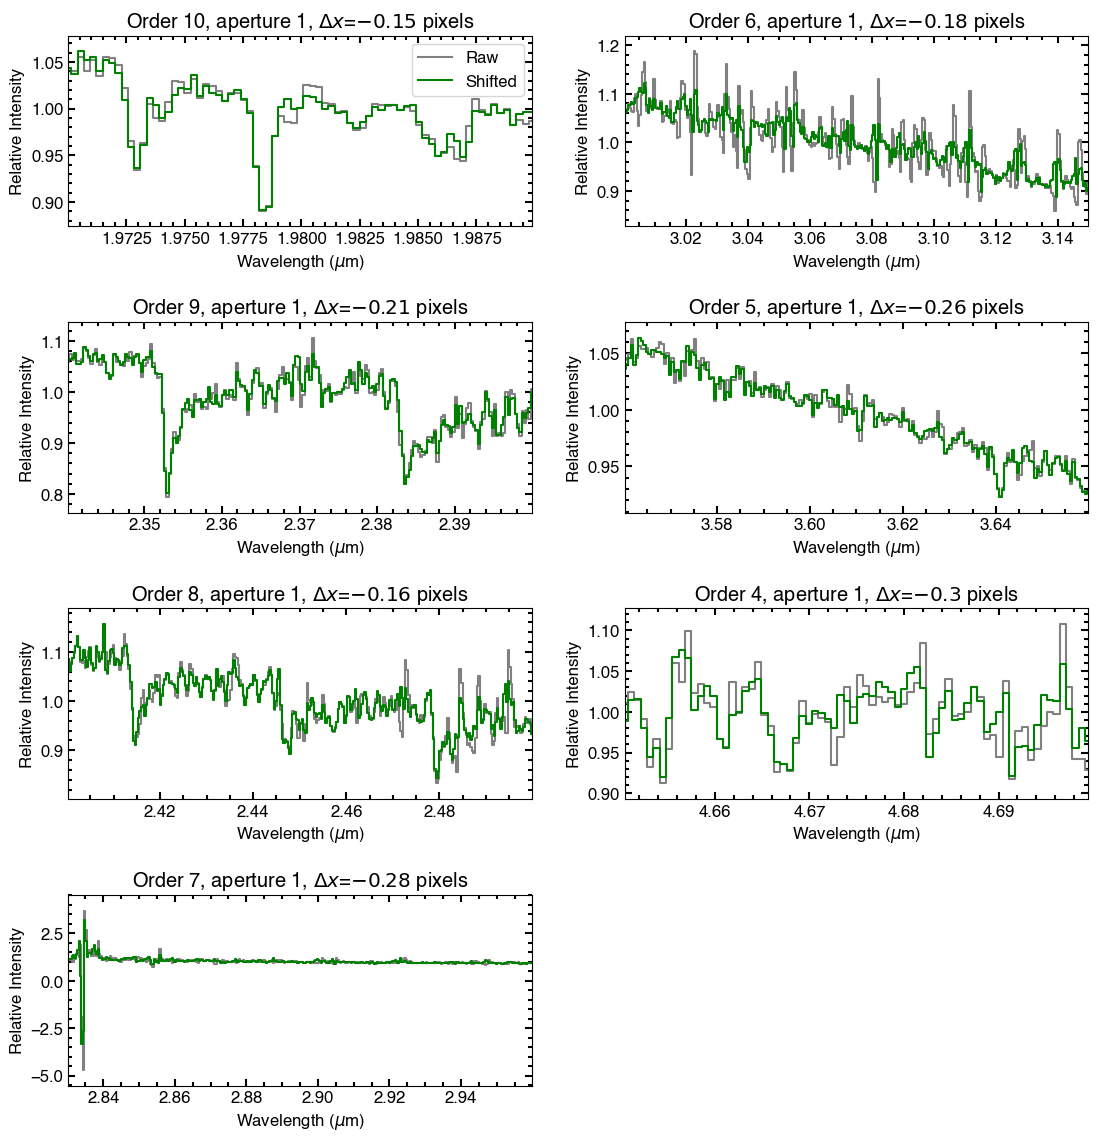

INFO:  Correcting spectra.
INFO:  Wrote file calspec23-24_telluric.fits to proc/.
INFO:  Wrote file calspec23-24.fits to proc/.


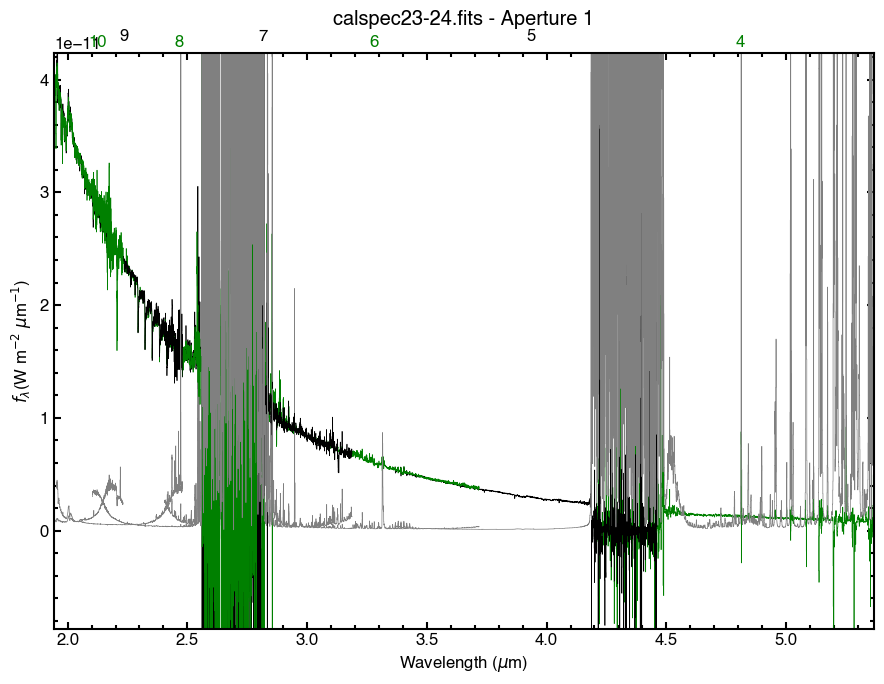

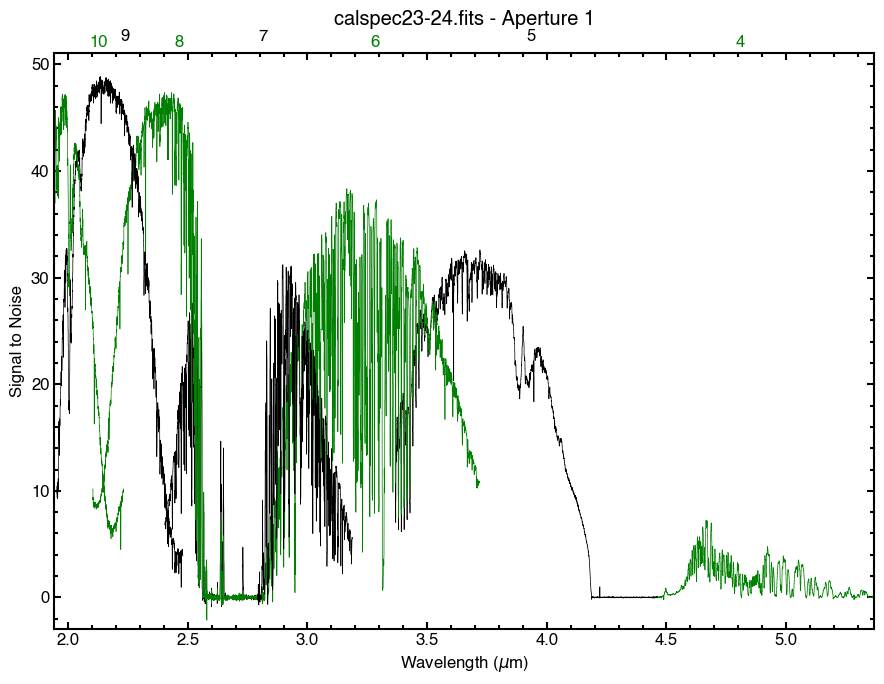

In [12]:
# ============================================================================
# TELLURIC CORRECTION
# ============================================================================
# Correct science spectrum for telluric absorption using standard star

ps.telluric.telluric(obj_name+'.fits',
                     std_name+'.fits',
                     std_name,
                     'calspec'+files,
                     write_model_spectra=write_model_spectra)


# Checking your outputs

You should find several output files in your cals and proc folders that allow you to visualize the calibrations and extractions. In addition, you can read in the spectrum and visualize it with plot_spectra.py


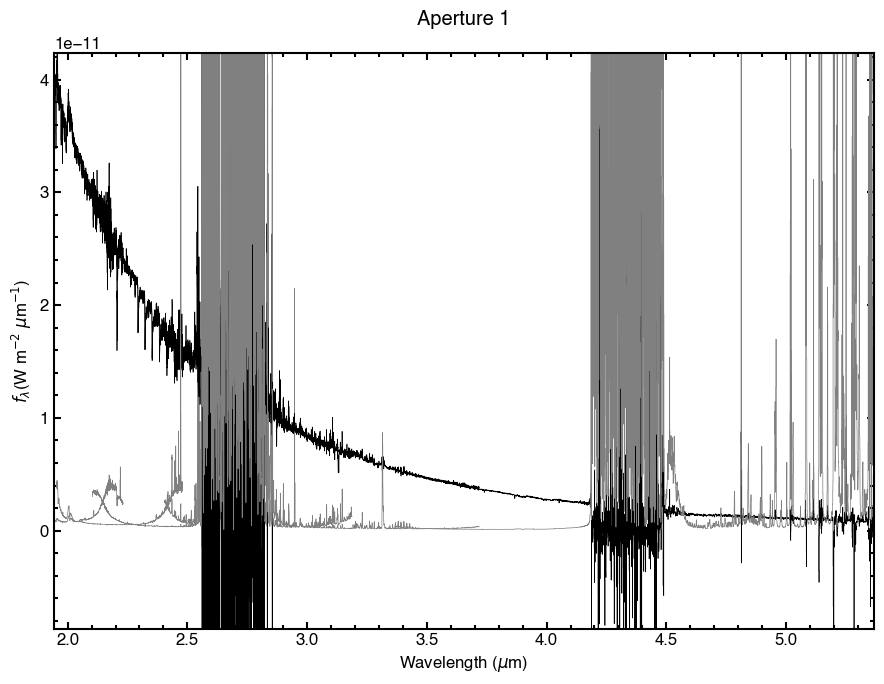

In [13]:
# ============================================================================
# PLOT RESULTS
# ============================================================================

from pyspextool.plot.plot_spectra import plot_spectra

file = 'calspec1-8.fits'
ax = plot_spectra(proc+file,
                  colors='k',
                  ytype="flux and uncertainty",
                  order_numbers=False)
